# Importer les librairies

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Importer les données

In [2]:
data = pd.read_csv("Data/titanic.csv")
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Questions

## 1. Préparation des données

Remplissez la function `preprocess` ci-dessus. Celle-ci doit:
1. Supprimez les colonnes `PassengerId`, `Name`, `Ticket`, `Cabin`.
2. Supprimez les lignes contenant au moins une valeur manquante.
3. Créer une variable `FamilySize` qui est correspond à `SibSp` + `Parch` + 1. Supprimez les variables `SibSp` et `Parch`.
4. Recalculer le prix du billet `Fare` en divisant `Fare` par `FamilySize`.
5. Encoder les variables qualitatives `Sex`, `Embarked` avec l'argument `drop_first=True`.

In [3]:
def preprocess(data: pd.DataFrame) -> pd.DataFrame:
    
    """La fonction prépare les données à l'analyse.
    
    Args:
        data (pd.DataFrame): La dataframe originale
        
    Returns:
        pd.DataFrame: La dataframe preprocessé et prête à être analysée.
    """
    
    # Faire une copy de la dataframe originale
    data_preprocessed = data.copy()
    
    # Supprimez les variables `PassengerId`, `Name`, `Ticket` & `Cabin`
    data_preprocessed.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"], inplace=True)
    
    # Supprimez lignes contenant au moins une valeur manquante
    data_preprocessed.dropna(inplace=True)
    
    # Créer une variable `FamilySize` et supprimez les variables `SibSp` et `Parch`
    data_preprocessed["FamilySize"] = data_preprocessed["SibSp"] + data_preprocessed["Parch"] + 1
    data_preprocessed.drop(columns=["SibSp", "Parch"], inplace=True)
    
    # Recalculer le prix du billet
    data_preprocessed["Fare"] = data_preprocessed["Fare"] / data_preprocessed["FamilySize"]
    
    # Encode (OHE) `Sex` & `Embarked`
    data_preprocessed = pd.get_dummies(data_preprocessed, columns=["Sex", "Embarked"], drop_first=True)
    
    # CHECK: NE PAS TOUCHER
    for col in ["PassengerId", "Name", "Ticket", "Cabin", "SibSp", "Parch"]:
        assert col not in data_preprocessed, f"{col} n'a pas été retiré."
    assert data_preprocessed.isna().sum().sum() == 0, "Il reste encore des NaN à supprimer."
    assert "FamilySize" in data_preprocessed.columns, "La colonne `FamilySize` n'a pas été créée."
    assert data_preprocessed.loc[0, "Fare"] == 3.625, "La colonne `Fare` n'a pas été recalculée."
    for col in [col for col in data_preprocessed if col.startswith("Embarked")]:
        assert data_preprocessed[col].nunique() == 2, f"{col} n'a pas été encodé."
    for col in [col for col in data_preprocessed if col.startswith("Sex")]:
        assert data_preprocessed[col].nunique() == 2, f"{col} n'a pas été encodé."
    
    return data_preprocessed

Le résultat de la function doit vous donner exactement le tableau ci-dessous.

In [4]:
# Preprocess les données à l'aide de la function `preprocess`
data_clean = preprocess(data)
display(data_clean)

,Survived,Pclass,Age,Fare,FamilySize,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,3.625000,2,True,False,True
1,1,1,38.0,35.641650,2,False,False,False
2,1,3,26.0,7.925000,1,False,False,True
3,1,1,35.0,26.550000,2,False,False,True
4,0,3,35.0,8.050000,1,True,False,True
...,...,...,...,...,...,...,...,...
885,0,3,39.0,4.854167,6,False,True,False
886,0,2,27.0,13.000000,1,True,False,True
887,1,1,19.0,30.000000,1,False,False,True
889,1,1,26.0,30.000000,1,True,False,False


## 2. Inférence statistique (4 pts)

### Q1: L'âge moyen des passagers du Titanic est-il le même que l'âge moyen de la population en 1912 (28 ans) ?

#### 1.1 Identifier la ou les variables d’intérêt et spécifier le type
La variable d'intérêt est la suivante : 
 - **Age** : variable qui indique l'âge de chaque passager

Type de la variable :
 - **Age** : quantitative continue

#### 1.2 Réaliser une visualisation appropriée selon la ou les variables
Pour cette question, nous avons choisi d’utiliser un histogramme car ce dernier est généralement adapté pour les variables quantitatives. Il nous permettra d’avoir un visuel sur la répartition des âges.

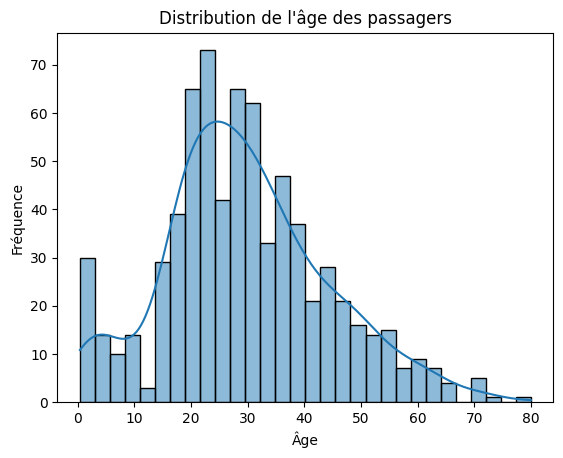

In [5]:
# Histogramme de l'âge des passagers
sns.histplot(data_clean["Age"], kde=True, bins=30)
plt.title('Distribution de l\'âge des passagers')
plt.xlabel('Âge')
plt.ylabel('Fréquence')
plt.show()

#### 1.3 Enoncer une hypothèse nulle et une hypothèse alternative considérant la ou les variables identifiées.
Notre hypothèse nulle (H<sub>0</sub>) est la suivante : L’âge moyen des passagers du Titanic est égal à 28 ans, ce qui représente l’âge moyen de la population en 1912.

**H<sub>0</sub> : μ = 28**

Notre hypothèse alternative (H<sub>1</sub>) est la suivante : L’âge moyen des passagers du Titanic n’est pas égal à 28 ans, ce qui représente l’âge moyen de la population en 1912.

**H<sub>1</sub> : μ =/= 28**

#### 1.4 Identifier le test statistique approprié selon les hypothèses énoncées
Selon nous, le test statistique approprié est le t-test pour un échantillon. Ce test nous permettra de comparer la moyenne de l’échantillon avec notre valeur données (28 ans) afin de savoir si elle diffère de manière significative.
Comme nous n’avons pas accès aux valeurs détaillées concernant la population générale, le z-test ne peut pas être utilisé. Le t-test, lui, est parfait dans ce contexte car il repose sur une estimation.

#### 1.5 Vérifier la validation des assomptions selon le test identifié
Concernant le t-test, les assomptions sont les suivantes :
 - L'échantillon est aléatoire
 - La taille de l'échantillon est supérieur à 30 ou la population est normalement distribuée

L'échantillon possède bien plus de 30 valeurs dans notre cas, car notre jeu de données possède la moitié des passagers du Titanic selon l'Encyclopedia Titanica.
Nous n'avons pas plus d'informations sur la sélection des passagers, mais on estime que cet échantillon est aléatoire.

Source : https://campus.lakeforest.edu/frank/FILES/MLFfiles/Bio150/Titanic/TitanicMETA.pdf

#### 1.6 Calculer la statistique ainsi que la p-valeur
Selon la formule suivante nous permettant de calculer la statistique t :
$$ t = \frac{\bar{X} - \mu}{s / \sqrt{n}} $$

In [25]:
# Variables
sample_mean = np.mean(data_clean["Age"]) # la moyenne de l'échantillon
sample_std = np.std(data_clean["Age"], ddof=1) # l'écart type de la population est inconnue
mu = 28 # la moyenne de la population est supposée être 28
n = len(data_clean["Age"]) # la taille de l'échantillon

# Calcul de la statistique t
t = (sample_mean - mu)/(sample_std / np.sqrt(n))

print("La statistique t est :", t)

# Calcul de la p-valeur
p_valeur = stats.t.cdf(-abs(t), df=n-1) * 2

print("La p-valeur est :", p_valeur)

La statistique t est : 3.0233009800374053
La p-valeur est : 0.002590259537786662


#### 1.7 Prendre une décision à partir de la p-valeur et d'un seuil alpha de 5%

Le seuil est défini via la variable "alpha" (0.05).
Le calcul est fait directement entre la "p_valeur" du point précédent et "alpha" afin de rejetter ou non l'hypothèse nulle.

In [7]:
# Seuil alpha
alpha = 0.05

# Si p-valeur < alpha, on rejète l'hypothèse nulle
if p_valeur < alpha:
    print("Avec un seuil alpha", str(alpha), "on rejette l'hypothèse nulle.")
    
# Si p-valeur > alpha, on ne rejète pas l'hypothèse nulle
else:
    print("Avec un seuil alpha", str(alpha), "on ne rejette pas l'hypothèse nulle.")

Avec un seuil alpha 0.05 on rejette l'hypothèse nulle.


#### 1.8 Interpréter le résultat et évaluer la taille de l'effet
??

### Q2: La survie dépend-elle de la classe du passager ?

#### 2.1 Identifier la ou les variables d’intérêt et spécifier le type
Les variables d'intérêts sont les suivantes : 
 - **Survived** : variable qui nous indique si la personne a survécu ou non (0 = morte, 1 = survécu)
 - **Pclass** : variable qui nous indique la classe de la personne (1 = Première classe, 2 = Deuxième classe, 3 = Troisième classe)

Type des variables :
 - **Survived** : qualitative binaire
 - **Pclass** : qualitative ordinal (trois valeurs différentes pouvant être hierarchisées)


#### 2.2 Réaliser une visualisation appropriée selon la ou les variables
Pour cette question, nous avons décidé d'utiliser un diagramme à barres groupées (grouped bar chart). Ce dernier est très efficace lors de la relation entre deux variables qualitatives. Cela nous permet d'avoir trois groupes de barres (les classes) qui contiennent chaucun 2 barres (les personnes qui ont survécu ou non).

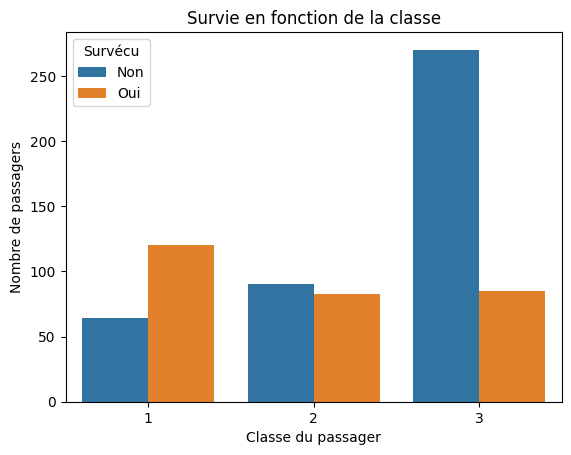

In [8]:
sns.countplot(data=data_clean, x='Pclass', hue='Survived')
plt.title('Survie en fonction de la classe')
plt.xlabel('Classe du passager')
plt.ylabel('Nombre de passagers')
plt.legend(title='Survécu', labels=['Non', 'Oui'])
plt.show()

#### 2.3 Enoncer une hypothèse nulle et une hypothèse alternative considérant la ou les variables identifiées.
Notre hypothèse nulle (H<sub>0</sub>) est la suivante : La survie est indépendante de la classe du passager.

**H<sub>0</sub> : P(Survived ∩ Pclass) = P(Survived) x P(Pclass)**

Notre hypothèse alternative (H<sub>1</sub>) est la suivante : La survie dépend de la classe du passager.

**H<sub>1</sub> : P(Survived ∩ Pclass) =/= P(Survived) x P(Pclass)**

#### 2.4 Identifier le test statistique approprié selon les hypothèses énoncées
Dans cette situation, le test du Chi-carré d’indépendance (Chi-Square independence test) est le plus approprié, car il permet de déterminer si des variables catégoriques sont indépendentes les unes des autres.

#### 2.5 Vérifier la validation des assomptions selon le test identifié
Concernant le test sélectionné, nous devons vérifier deux assomptions : 
- Les échantillons sont aléatoires
- Pour chaque combinaison des niveaux des variables, nous avons besoin d’au moins 5 valeurs

Comme pour la question précédente, nous allons partir sur le principe que les échantillons sont aléatoires. Le code ci-dessous nous valide le deuxième point.

In [9]:
# Tableau de contingence
contingency_table = pd.crosstab(data_clean['Pclass'], data_clean['Survived'])

# Effectifs théoriques dans chaque cellule du tableau
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print("Effectifs théoriques dans chaque cellule du tableau :")
print(expected)

Effectifs théoriques dans chaque cellule du tableau :
[[109.57303371  74.42696629]
 [103.02247191  69.97752809]
 [211.40449438 143.59550562]]


#### 2.6 Calculer la statistique ainsi que la p-valeur
Selon la formule suivante nous permettant de calculer la statistique :
$$ \chi^2 = \sum \frac{(O - E)^2}{E} $$

In [23]:
# Test du Chi-carré
chi2_stat, p_val, dof, ex = stats.chi2_contingency(contingency_table)

print("La statistique est :", chi2_stat)
print("La p-valeur est :", p_val)
print("Degrés de liberté :", dof)

La statistique est : 91.08074548791019
La p-valeur est : 1.6675060315554636e-20
Degrés de liberté : 2


#### 2.7 Prendre une décision à partir de la p-valeur et d'un seuil alpha de 5%

Le seuil est défini via la variable "alpha" (0.05).
Le calcul est fait directement entre la "p_valeur" du point précédent et "alpha" afin de rejetter ou non l'hypothèse nulle.

In [11]:
# Seuil alpha
alpha = 0.05

# Si p-valeur < alpha, on rejète l'hypothèse nulle
if p_valeur < alpha:
    print("Avec un seuil alpha", str(alpha), "on rejette l'hypothèse nulle.")
    
# Si p-valeur > alpha, on ne rejète pas l'hypothèse nulle
else:
    print("Avec un seuil alpha", str(alpha), "on ne rejette pas l'hypothèse nulle.")

Avec un seuil alpha 0.05 on rejette l'hypothèse nulle.


#### 2.8 Interpréter le résultat et évaluer la taille de l'effet
??

### Q3: Existe-t-il une différence d'âge entre les passagers qui ont survécu et les passagers décédés ?

#### 3.1 Identifier la ou les variables d’intérêt et spécifier le type
Les variables d'intérêts sont les suivantes : 
 - **Age** : variable qui nous indique l'âge de chaque passager
 - **Survived** : variable qui nous indique si la personne a survécu ou non (0 = morte, 1 = survécu)

Type des variables :
 - **Age** : quantitative continue
 - **Survived** : qualitative binaire

#### 3.2 Réaliser une visualisation appropriée selon la ou les variables
Pour cette question, nous avons sélectionné un diagramme "boxplot", car ce dernier est recommandé lorsqu'il y a une relation entre une variable qualitative et une variable quantitative.

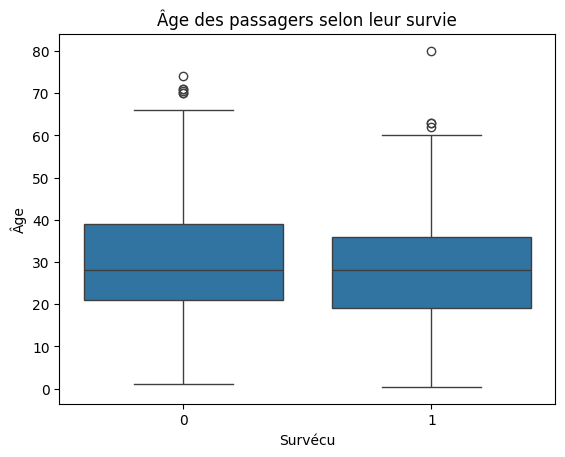

In [13]:
# Boxplot de l'âge des passagers selon leur survie
sns.boxplot(data=data_clean, x='Survived', y='Age')
plt.title('Âge des passagers selon leur survie')
plt.xlabel('Survécu')
plt.ylabel('Âge')
plt.show()

#### 3.3 Enoncer une hypothèse nulle et une hypothèse alternative considérant la ou les variables identifiées.
Notre hypothèse nulle (H<sub>0</sub>) est la suivante : L’âge moyen des passagers survivants est égal à l’âge moyen des passagers décédés.

**H<sub>0</sub> : μ<sub>Survécu</sub> =  μ<sub>Décédé</sub>**

Notre hypothèse alternative (H<sub>1</sub>) est la suivante : L’âge moyen des passagers survivants est différent de l’âge moyen des passagers décédés.

**H<sub>1</sub> : μ<sub>Survécu</sub> =/=  μ<sub>Décédé</sub>**

#### 3.4 Identifier le test statistique approprié selon les hypothèses énoncées
Selon nous, le test approprié est le t-test à deux échantillons (two-sample t-test), car ce dernier nous permet de comparer deux moyennes d'une population. Généralement cette population est inconnue, bien qu'elle soit connue dans notre exercice, ce test devrait tout de même fonctionner.

#### 3.5 Vérifier la validation des assomptions selon le test identifié
Les assomptions à vérifier sont les suivantes :
 - Les échantillons sont aléatoires.
 - Les échantillons sont indépendants les uns des autres.
 - La taille des échantillons est supérieure à 30, ou les populations sont normalement distribuées.

Comme pour les questions précédentes, nous allons partir sur le principe que les échantillons sont aléatoires. Le code ci-dessous nous valide les deux autres points.

In [24]:
# Variables
group_survived = data_clean[data_clean['Survived'] == 1]['Age']
group_died = data_clean[data_clean['Survived'] == 0]['Age']

# Test de Levene pour l'égalité des variances
stat, p_value = stats.levene(group_survived, group_died)

# Seuil alpha
alpha = 0.05

# Si p-valeur < alpha, les variances ne peuvent pas être considérées comme égales
if p_value < alpha:
    print("Avec un seuil alpha", str(alpha), "les variances ne peuvent pas être considérées comme égales.")

# Si p-valeur > alpha, les variances peuvent être considérées comme égales
else:
    print("Avec un seuil alpha", str(alpha), "les variances peuvent être considérées comme égales.")

print (f'----------------------------')
print(f'Taille du groupe des survivants :', len(group_survived))
print(f'Taille du groupe des morts :', len(group_died))

Avec un seuil alpha 0.05 les variances peuvent être considérées comme égales.
----------------------------
Taille du groupe des survivants : 288
Taille du groupe des morts : 424


#### 3.6 Calculer la statistique ainsi que la p-valeur
Selon la formule suivante pour calculer la statistique t pour 2 échantillons :
$$ t = \frac{(\bar{X_1} - \bar{X_2}) - (\mu_1 - \mu_2)}{\sqrt{\frac{s_{1}^2}{n_1} + \frac{s_{2}^2}{n_2}}} $$

In [19]:
# Calcul de la statistique t et la p-valeur
t, p_valeur = stats.ttest_ind(
    group_survived,
    group_died,
    alternative="two-sided",
    equal_var=False
)

print("La statistique t est de : " + str(t))
print("La p-valeur associée est de : " + str(p_valeur))

La statistique t est de : -2.184486214939826
La p-valeur associée est de : 0.02931497754601072


#### 3.7 Prendre une décision à partir de la p-valeur et d'un seuil alpha de 5%

Le seuil est défini via la variable "alpha" (0.05).
Le calcul est fait directement entre la "p_valeur" du point précédent et "alpha" afin de rejetter ou non l'hypothèse nulle.

In [20]:
# Si p-valeur < alpha, on rejète l'hypothèse nulle
if p_valeur < alpha:
    print("Avec un seuil alpha", str(alpha), "on rejète l'hypothèse nulle.")
    
# Si p-valeur > alpha, on ne rejète pas l'hypothèse nulle
else:
    print("Avec un seuil alpha", str(alpha), "on ne rejète pas l'hypothèse nulle.")

Avec un seuil alpha 0.05 on rejète l'hypothèse nulle.


#### 3.8 Interpréter le résultat et évaluer la taille de l'effet
??

### Q4: Existe-t-il une relation entre l'âge des passagers et le prix des billets ?

#### 4.1 Identifier la ou les variables d’intérêt et spécifier le type
Les variables d'intérêts sont les suivantes : 
 - **Age** : variable qui indique l'âge de chaque passager
 - **Fare** : variable qui indique le prix du billet par passager (c'est le prix total pour une famille / divisé par la taille de la famille)

Type des variables :
 - **Age** : quantitative continue
 - **Fare** : quantitative continue

#### 4.2 Réaliser une visualisation appropriée selon la ou les variables
Pour une relation entre deux variables quantitatives, nous avons décidé d'utiliser un nuage de points (scatter plot).

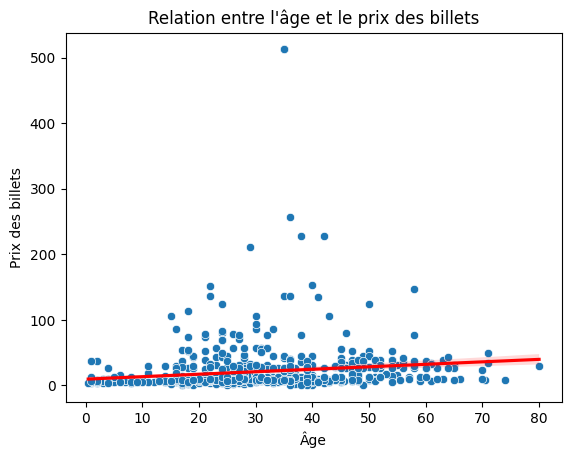

In [26]:
# Scatter plot de l'âge et du prix des billets
sns.scatterplot(data=data_clean, x='Age', y='Fare')
sns.regplot(data=data_clean, x='Age', y='Fare', scatter=False, color='red')  # Ligne de régression afin de visualiser la tendance
plt.title("Relation entre l'âge et le prix des billets")
plt.xlabel("Âge")
plt.ylabel("Prix des billets")
plt.show()

#### 4.3 Enoncer une hypothèse nulle et une hypothèse alternative considérant la ou les variables identifiées.
Notre hypothèse nulle (H<sub>0</sub>) est la suivante : Il n’existe pas de relation significative entre l’âge des passagers et le prix des billets.

**H<sub>0</sub> : ρ = 0**

Notre hypothèse alternative (H<sub>1</sub>) est la suivante : Il existe une relation significative entre l’âge des passagers et le prix des billets.

**H<sub>1</sub> : ρ =/= 0**

*ρ = coefficient de corrélation de Pearson, il examine la relation entre deux variables et détermine l'influence de l'une sur l'autre.*

#### 4.4 Identifier le test statistique approprié selon les hypothèses énoncées
??

#### 4.5 Vérifier la validation des assomptions selon le test identifié
??

#### 4.6 Calculer la statistique ainsi que la p-valeur
??

#### 4.7 Prendre une décision à partir de la p-valeur et d'un seuil alpha de 5%

Le seuil est défini via la variable "alpha" (0.05).
Le calcul est fait directement entre la "p_valeur" du point précédent et "alpha" afin de rejetter ou non l'hypothèse nulle.

#### 4.8 Interpréter le résultat et évaluer la taille de l'effet
??

Pour chacune des questions 1 à 4 ci-dessus, argumenter de manière statistique en effectuant chacune des étapes suivantes:
1. Identifier la ou les variables d'intérêt et spécifier le type.
2. Réaliser une visualisation appropriée selon la ou les variables.
3. Enoncer une hypothèse nulle et une hypothèse alternative considérant la ou les variables identifiées.
4. Identifier le test statistique approprié selon les hypothèses énoncées.
5. Vérifier la validation des assumptions selon le test identifié.
6. Calculer la statistique ainsi que la p-valeur.
7. Prendre une décision à partir de la p-valeur et d'un seuil alpha de 5%.
8. Interpréter le résultat et évaluer la taille de l'effet.

Quelques liens utiles pour la taille de l'effet:
* [https://rpsychologist.com/cohend/](https://rpsychologist.com/cohend/)
* [https://datatab.net/tutorial/effect-size-independent-t-test](https://datatab.net/tutorial/effect-size-independent-t-test)
* [https://www.simplypsychology.org/effect-size.html](https://www.simplypsychology.org/effect-size.html)

## 3. Data mining (2 pts)

### Q1: Effectuer une analyse statistique à l'aide de la régression logistique avec comme variable dépendente la variable `Survived`. Interpréter les coefficients et discuter de leur importance statistique en vous appuyant sur leur p-valeur.

### Q2: Effecter une analyse statistique à l'aide d'un arbre de classification avec comme variable dépendente la variable `Survived` et une profondeur maximale de 4. Visualiser l'arbre et expliquer quelques décisions.

**Conclusion: Interpréter les résultats des deux analyses statistiques et résumer les points importants de votre étude.**